In [1]:
# =======================
# IMPORTING LIBRARIES
# =======================

# Standard Libraries
import os
import time
import warnings
import numpy as np
import pandas as pd
import joblib

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
from scipy.stats import pointbiserialr

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Gradient Boosting Frameworks
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
# import lightgbm as lgb  # Alternative import for LightGBM

# Ignore warnings
warnings.filterwarnings('ignore')

# Set Seaborn style
sns.set_style("whitegrid")

# 1.0: Data Understanding

## 1.1: Load dataset

In [30]:
file_path = "../data/preprocessed/preprocessed_data.csv"
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT,IS_RAINY_SEASON,IS_HOT_SEASON,PPT_TMAX_RATIO,SOILMOISTURE_TMAX_INTERACTION,PPT_CATEGORY,TMAX_CATEGORY,SOILMOISTURE_CATEGORY,LOCUST_RISK_SCORE
0,0.980170,0.859390,1985,1,0.0,27.55,0.0,0,0,0,0.000000,0.000,Low,Low,Low,8.265
1,0.961039,0.859390,1985,1,0.6,28.00,0.0,0,0,0,0.020690,0.000,Low,Low,Low,8.640
2,0.925170,0.859390,1985,1,0.0,26.81,0.0,0,0,0,0.000000,0.000,Low,Low,Low,8.043
3,0.953052,0.447637,1985,1,34.9,32.04,0.1,0,0,0,1.056295,3.204,Medium,Medium,Low,23.602
4,0.887640,0.859390,1985,1,0.8,31.17,0.1,0,0,0,0.024868,3.117,Low,Medium,Low,9.701


## 1.2: Filter dataset for Somalia only

In [27]:
# df['COUNTRYNAME']=df['COUNTRYNAME'].str.strip()
somalia_df = df[df['COUNTRYNAME']=='Somaliland']

# Display first 5 rows of Somalia-specific data
somalia_df.head()

,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT,IS_RAINY_SEASON,IS_HOT_SEASON,PPT_TMAX_RATIO,SOILMOISTURE_TMAX_INTERACTION,PPT_CATEGORY,TMAX_CATEGORY,SOILMOISTURE_CATEGORY,LOCUST_RISK_SCORE


## 1.3: Dataset structure

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79528 entries, 0 to 79527
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   REGION         79528 non-null  object 
 1   COUNTRYNAME    79528 non-null  object 
 2   STARTYEAR      79528 non-null  int64  
 3   STARTMONTH     79528 non-null  int64  
 4   PPT            79528 non-null  float64
 5   TMAX           79528 non-null  float64
 6   SOILMOISTURE   79528 non-null  float64
 7   LOCUSTPRESENT  79528 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 4.9+ MB


## 1.4: Display basic statistics

In [28]:
# Display basic statistics (excluding STARTYEAR and STARTMONTH)
df_filtered = df.drop(columns=["STARTYEAR", "STARTMONTH"])

df_summary = df_filtered.describe()
display(df_summary)


,PPT,TMAX,SOILMOISTURE
count,79528.000000,79528.000000,79528.00000
mean,46.459986,30.557233,23.03873
std,71.661346,6.237993,50.54590
min,0.000000,2.100000,0.00000
25%,1.000000,27.090000,0.10000
50%,15.700000,30.750000,2.90000
75%,64.800000,34.720000,21.70000
max,906.700000,177.000000,582.60000


### Summary:
This summary provides key statistics for PPT (Precipitation), TMAX (Maximum Temperature), and SOILMOISTURE. The mean values indicate that, on average, precipitation is around 46.46 mm, maximum temperature is 30.56°C, and soil moisture is 23.04%. However, the high standard deviation of 71.66 mm for precipitation suggests significant variability in rainfall across the dataset. The temperature values are more stable, with a standard deviation of 6.24°C, while soil moisture has a wide range, spanning from 0 to 582.6%, implying extreme cases of aridity and water saturation.

### Insight:
The recorded 177°C maximum temperature is almost certainly an outlier, as such a value is physically impossible. Similarly, the 582.6% soil moisture value is questionable, as soil moisture should not exceed 100%. The dataset captures both extremely dry and wet regions, reflecting diverse climate conditions. Further validation and correction of these extreme values are needed.lues


## 1.5: Unique values in categorical columns

In [29]:
df[['REGION', 'COUNTRYNAME', 'LOCUSTPRESENT']].nunique()

REGION           369
COUNTRYNAME       42
LOCUSTPRESENT      2
dtype: int64

## 1.6: Check for missing values in each column

In [30]:
df.isnull().sum()

REGION           0
COUNTRYNAME      0
STARTYEAR        0
STARTMONTH       0
PPT              0
TMAX             0
SOILMOISTURE     0
LOCUSTPRESENT    0
dtype: int64

## 1.7: Compare summary statistics 

In [31]:

# Compare summary statistics (Global summary excluding STARTYEAR and STARTMONTH)
df_filtered.describe().loc[['mean', 'min', 'max']].T


,mean,min,max
PPT,46.459986,0.0,906.7
TMAX,30.557233,2.1,177.0
SOILMOISTURE,23.038730,0.0,582.6


### Summary:
Globally, the dataset shows that precipitation varies widely, from 0 mm to 906.7 mm, indicating areas with extreme dryness and heavy rainfall. The mean temperature of 30.56°C suggests generally warm conditions, though the 177°C maximum is unrealistic and likely an error. Soil moisture also varies significantly, with an average of 23.04%, but an extreme maximum of 582.6%, which seems unrealistic.


### Insight:

:The dataset shows extreme variations in precipitation, indicating both very wet and dry conditions. While maximum temperature remains relatively stable, the recorded 177°C is likely an error. Soil moisture also exhibits a significant spread, possibly due to differences in soil types or extreme rainfall events. Data cleaning is necessary to address these extreme value


In [32]:
# Summary statistics for Somalia data (excluding STARTYEAR and STARTMONTH)
somalia_df_filtered = somalia_df.drop(columns=["STARTYEAR", "STARTMONTH"])
somalia_df_filtered.describe().loc[['mean', 'min', 'max']].T

,mean,min,max
PPT,25.156681,0.0,404.80
TMAX,33.099882,23.7,43.75
SOILMOISTURE,4.273048,0.0,114.60


### Summary:
Focusing on Somalia, precipitation levels are lower than the global average, with a mean of 25.68 mm compared to 46.46 mm globally. Temperature is also slightly lower on average, at 30.10°C, and soil moisture is significantly lower, at only 4.27%, highlighting the country's arid nature. The maximum temperature is 43.76°C, which is extreme but plausible.

### Insight:
Somalia experiences significantly lower precipitation and soil moisture compared to global averages, making it much drier. While recorded temperatures appear reasonable, extreme values still require verification. The low soil moisture levels suggest a heightened risk of drought. Further analysis should explore how temperature and precipitation impact locust presence.

## 1.8: Detecting outliers

In [29]:
# Function to detect outliers
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    outlier_percentage = (len(outliers) / len(data)) * 100
    print(f"Outliers in {column}: {len(outliers)} ({outlier_percentage:.2f}%)")
    return outliers

# Check outliers for each numerical feature
for col in ["PPT", "TMAX", "SOILMOISTURE"]:
    detect_outliers(somalia_df, col)

ZeroDivisionError: division by zero

### Insight:    
  - *PPT (Precipitation)*: 8.76% outliers, indicating extreme rainfall events.  
  - *TMAX (Temperature)*: 3.41% outliers, suggesting occasional extreme temperatures.  
  - *SOILMOISTURE*: 13.18% outliers, highlighting significant deviations in soil moisture levels, which could indicate flooding or drought condinstio.  

In [21]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 9198


In [22]:
# Remove duplicate rows
df_cleaned = df.drop_duplicates()
print(f"Number of rows after removing duplicates: {df_cleaned.shape[0]}")

Number of rows after removing duplicates: 70330


In [31]:
# =========================
# CHECK CLASS DISTRIBUTION
# =========================

# Count occurrences of "YES" and "NO" in the target column
class_counts = df["LOCUSTPRESENT"].value_counts()

# Display class distribution
print("Class Distribution in LOCUSTPRESENT:")
print(class_counts)

Class Distribution in LOCUSTPRESENT:
LOCUSTPRESENT
0    54714
1    11587
Name: count, dtype: int64


In [32]:
# Apply SMOTE (Synthetic Minority Over-sampling Technique)

from imblearn.over_sampling import SMOTE, RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop(columns=["LOCUSTPRESENT"]), df["LOCUSTPRESENT"])

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=df.drop(columns=["LOCUSTPRESENT"]).columns)
df_balanced["LOCUSTPRESENT"] = y_resampled

# Display new class distribution
print("Balanced dataset class distribution:")
print(df_balanced["LOCUSTPRESENT"].value_counts())

# ------------------- Alternative Approaches (Commented Out) ------------------- #

# 1️⃣ Random Undersampling (Reduce majority class)
# undersampler = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(df.drop(columns=["LOCUSTPRESENT"]), df["LOCUSTPRESENT"])
# df_balanced = pd.DataFrame(X_resampled, columns=df.drop(columns=["LOCUSTPRESENT"]).columns)
# df_balanced["LOCUSTPRESENT"] = y_resampled
# print("Balanced dataset class distribution (Undersampling):")
# print(df_balanced["LOCUSTPRESENT"].value_counts())

# 2️⃣ Random Oversampling (Duplicate minority class)
# oversampler = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = oversampler.fit_resample(df.drop(columns=["LOCUSTPRESENT"]), df["LOCUSTPRESENT"])
# df_balanced = pd.DataFrame(X_resampled, columns=df.drop(columns=["LOCUSTPRESENT"]).columns)
# df_balanced["LOCUSTPRESENT"] = y_resampled
# print("Balanced dataset class distribution (Oversampling):")
# print(df_balanced["LOCUSTPRESENT"].value_counts())

ValueError: could not convert string to float: 'Low'

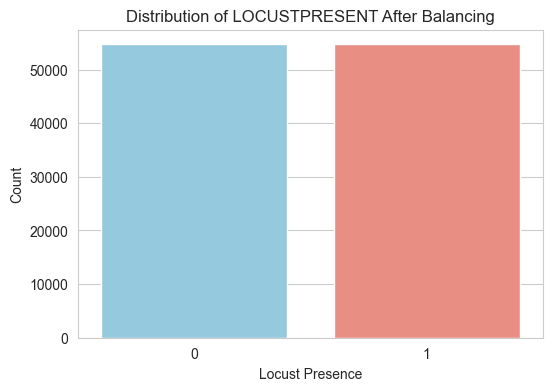

In [16]:
# Get class distribution AFTER balancing
class_counts = df_balanced["LOCUSTPRESENT"].value_counts()

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=["skyblue", "salmon"])
plt.xlabel("Locust Presence")
plt.ylabel("Count")
plt.title("Distribution of LOCUSTPRESENT After Balancing")
plt.show()

In [30]:
# Display min and max values for the selected features
features = ['PPT', 'TMAX', 'SOILMOISTURE']
ranges = df[features].agg(['min', 'max'])

print("Feature Ranges:")
print(ranges)

Feature Ranges:
       PPT   TMAX  SOILMOISTURE
min    0.0   2.10           0.0
max  906.7  46.71         100.0


# 2.0: Data Exploration

## 2.1: Visualization

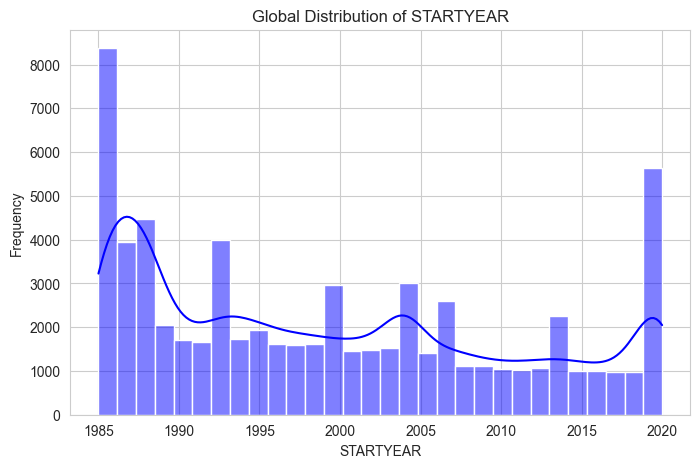

In [3]:
#  Global Distribution of STARTYEAR
plt.figure(figsize=(8, 5))
sns.histplot(df['STARTYEAR'], bins=30, kde=True, color="blue")
plt.title("Global Distribution of STARTYEAR")
plt.xlabel("STARTYEAR")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "global_distr_of_year"))

plt.show()

### Insight:
The dataset contains records spanning multiple decades, with a notable increase in data entries around 2020. This suggests either improved data collection or increased locust occurrences in recent years.

In [4]:
# Filter dataset for Somalia (assuming COUNTRYNAME is already cleaned)
somalia_df = df[df['COUNTRYNAME'].str.strip() == "Somaliland"].copy()

# Somalia Distribution of STARTYEAR
plt.figure(figsize=(8, 5))
sns.histplot(somalia_df['STARTYEAR'], bins=30, kde=True, color="blue")
plt.title("Somalia Distribution of STARTYEAR")
plt.xlabel("STARTYEAR")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "som_distr_of_year"))

plt.show()

AttributeError: Can only use .str accessor with string values!

### Insight:
The distribution of recorded locust presence across years shows fluctuations, with a sharp increase in reports after 2020. This could indicate a significant rise in locust outbreaks or an improvement in tracking and reporting methods. Earlier years have relatively scattered records, possibly due to inconsistent data collection or fewer reported incidents.

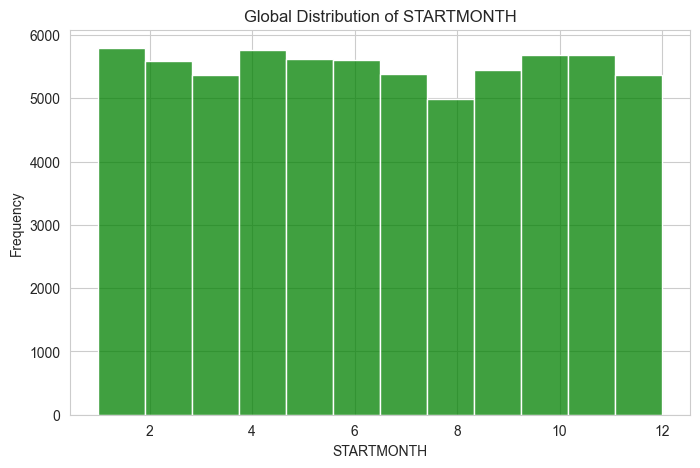

In [5]:
# Global Distribution of STARTMONTH
plt.figure(figsize=(8, 5))
sns.histplot(df['STARTMONTH'], bins=12, kde=False, color="green")
plt.title("Global Distribution of STARTMONTH")
plt.xlabel("STARTMONTH")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "global_distr_of_month"))

plt.show()

### Insight:
The distribution is fairly uniform across months, indicating that locust-related records are not concentrated in a specific season. However, a slightly higher count is observed in June.

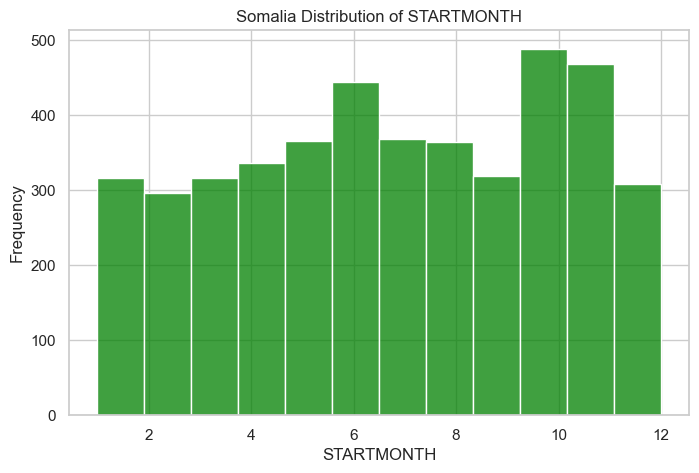

In [360]:
# Somalia Distribution of STARTMONTH
plt.figure(figsize=(8, 5))
sns.histplot(somalia_df['STARTMONTH'], bins=12, kde=False, color="green")
plt.title("Somalia Distribution of STARTMONTH")
plt.xlabel("STARTMONTH")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "soma_distr_of_month"))

plt.show()

### Insight:
Locust presence in Somalia is highly seasonal, with noticeable peaks in May and October-November. The lowest activity occurs in February, suggesting that environmental conditions during that time may not be favorable for locust survival or reproduction. The increase in late months might be linked to the rainy season, which provides the right conditions for locust swarms to develop.

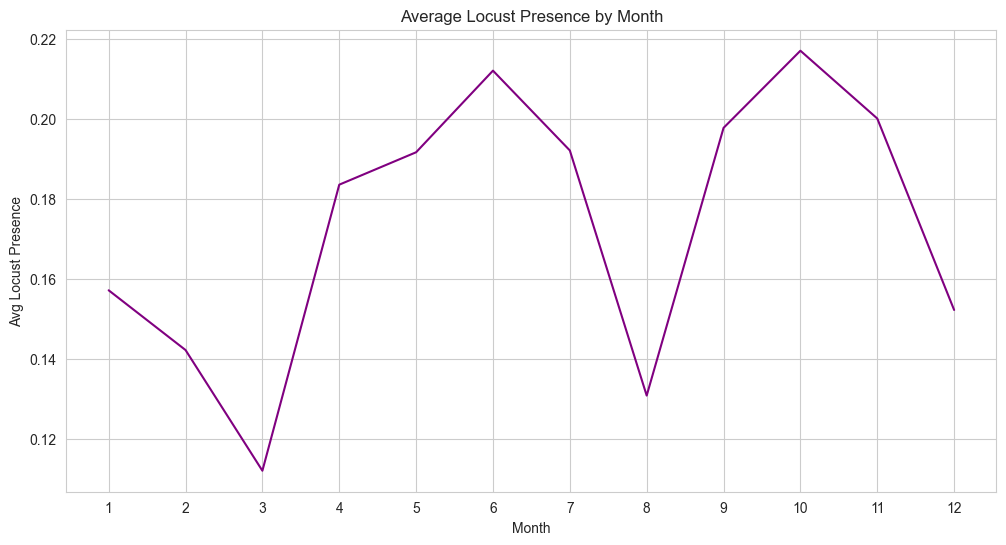

In [6]:
# Seasonal Trends in Locust Presence

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='STARTMONTH', y='LOCUSTPRESENT', estimator='mean', errorbar=None, color='purple')
plt.xticks(range(1, 13))
plt.title('Average Locust Presence by Month')
plt.xlabel('Month')
plt.ylabel('Avg Locust Presence')

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "locust_presence_over_months"))

plt.show()

### Insight:
Locust presence peaks from June to September, coinciding with the rainy season in many affected regions. This period provides ideal breeding conditions, such as increased vegetation and soil moisture. Lower presence in dry months (January–March) reflects the absence of favorable breeding environments.


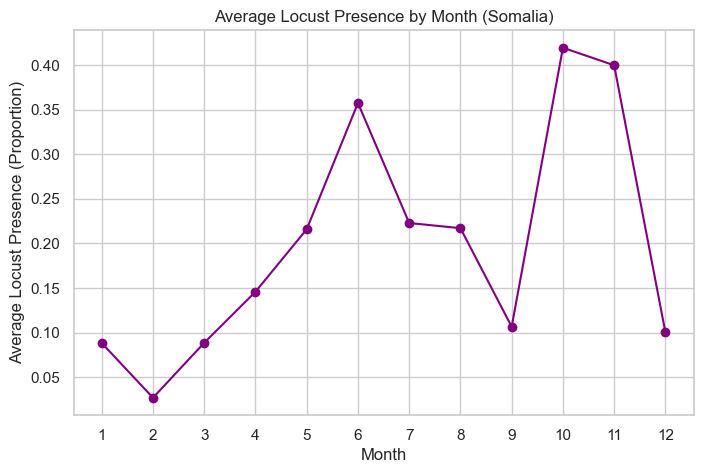

In [364]:
# Convert LOCUSTPRESENT to numeric if necessary
somalia_df['LOCUSTPRESENT'] = somalia_df['LOCUSTPRESENT'].map({'no': 0, 'yes': 1})

# Compute average locust presence by month for Somalia
avg_by_month = somalia_df.groupby("STARTMONTH")["LOCUSTPRESENT"].mean()

plt.figure(figsize=(8, 5))
avg_by_month.plot(kind="line", marker="o", color="purple")
plt.title("Average Locust Presence by Month (Somalia)")
plt.xlabel("Month")
plt.ylabel("Average Locust Presence (Proportion)")
plt.xticks(range(1, 13))
plt.grid(True)

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "som_locust_presence_over_months"))

plt.show()


### Insight:
Locust presence is highest from June to September, aligning with Somalia’s rainy season. This period provides optimal conditions for locust breeding, including increased vegetation and soil moisture. Lower presence in dry months (January–March) reflects the absence of breeding-friendly conditions.

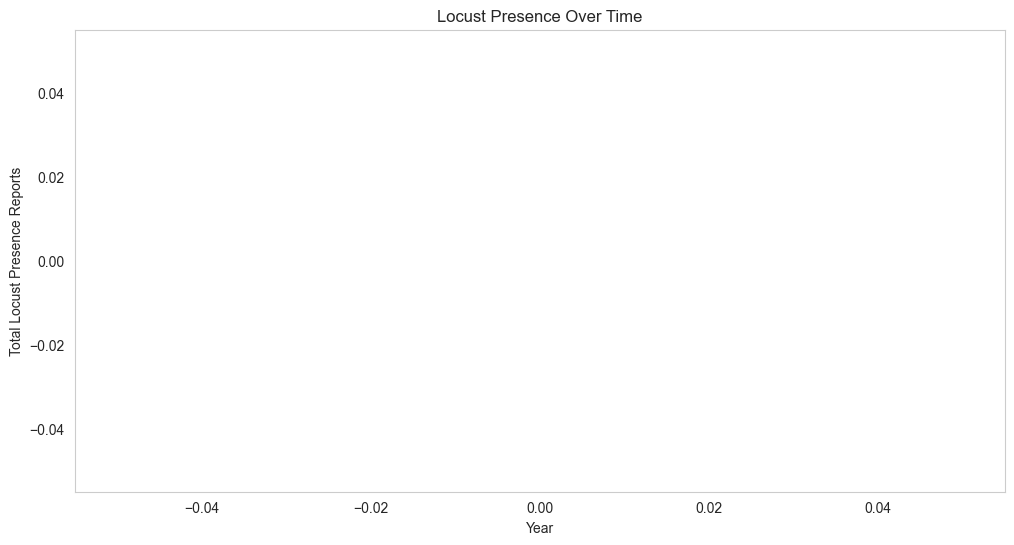

In [7]:
# Locust Presence Over Time
plt.figure(figsize=(12, 6))
yearly_counts = df[df['LOCUSTPRESENT'] == 'yes'].groupby('STARTYEAR').size()
yearly_counts.plot(kind='line', marker='o', color='red')
plt.xlabel("Year")
plt.ylabel("Total Locust Presence Reports")
plt.title("Locust Presence Over Time")
plt.grid()

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "locust_presence_over_time"))

plt.show()

### Insight:
Locust presence peaks around 2020, coinciding with the 2019–2022 East Africa locust crisis. This spike underscores the increasing frequency and severity of outbreaks in recent years. The gradual rise since 1985 suggests a link to climate change, which may be creating more favorable conditions for locusts.

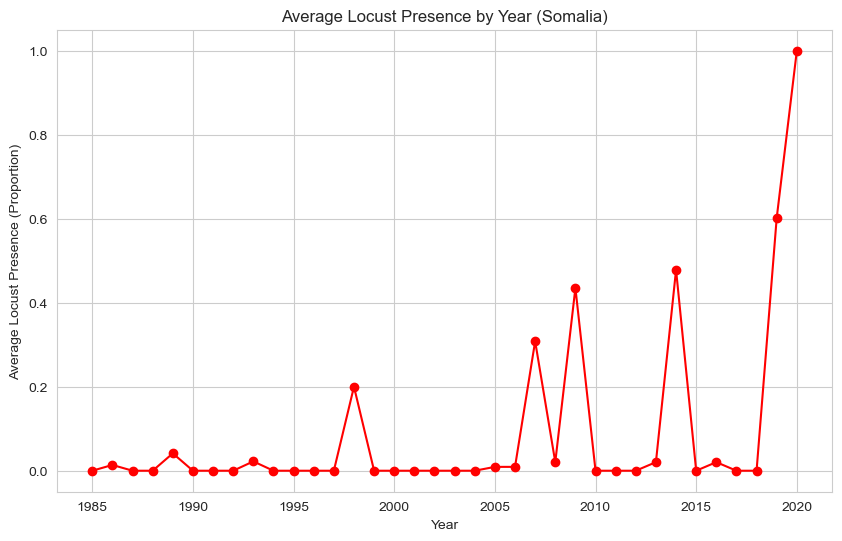

In [15]:
# Convert 'LOCUSTPRESENT' to numeric for somalia_df
somalia_df['LOCUSTPRESENT'] = somalia_df['LOCUSTPRESENT'].map({'no': 0, 'yes': 1})

# Compute average locust presence by year
avg_by_year = somalia_df.groupby("STARTYEAR")["LOCUSTPRESENT"].mean()

plt.figure(figsize=(10, 6))
avg_by_year.plot(kind="line", marker="o", color="red")
plt.title("Average Locust Presence by Year (Somalia)")
plt.xlabel("Year")
plt.ylabel("Average Locust Presence (Proportion)")
plt.grid(True)

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "som_locust_presence_over_years"))

plt.show()

### Insight:
Locust presence shows a gradual increase from 1985 to 2020, with a sharp spike around 2020. This aligns with the 2019–2022 East Africa locust crisis, driven by favorable climatic conditions like increased rainfall and vegetation. The trend suggests a potential link between climate change and rising locust outbreaks.  

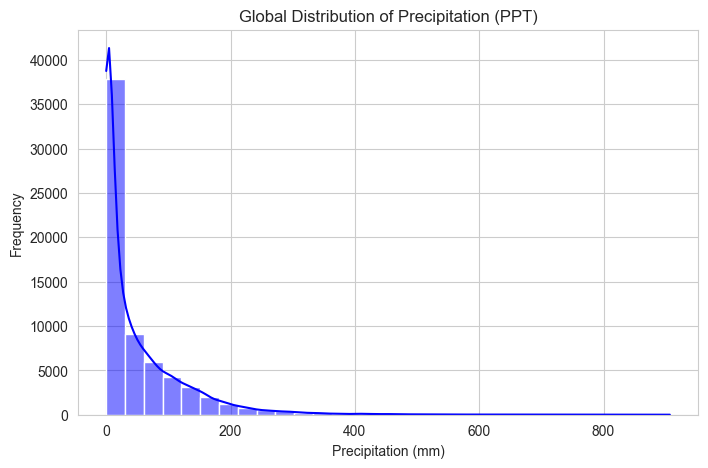

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(df['PPT'], bins=30, kde=True, color='blue')
plt.title("Global Distribution of Precipitation (PPT)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "distr_of_ppt"))

plt.show()

### Insight:
(Precipitation): The majority of values are very low, with a steep decline as precipitation increases. This suggests that locust occurrences are often recorded in drier conditions, though extreme precipitation events exist.

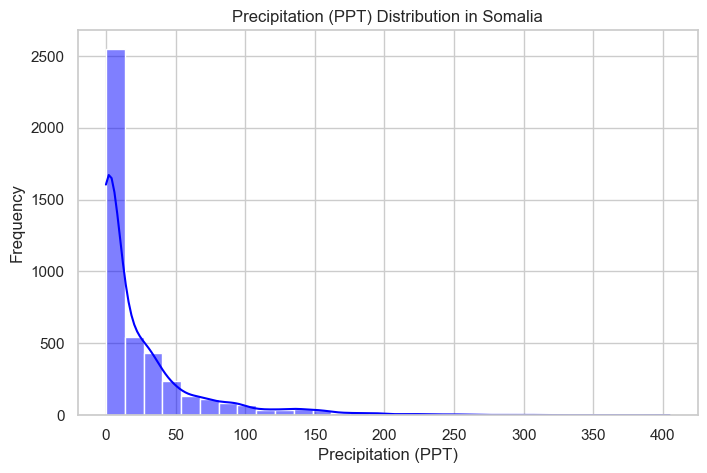

In [372]:
# Filter data for Somaliland (removing whitespace)
somalia_df = df[df['COUNTRYNAME'].str.strip() == "Somaliland"].copy()

# Set figure style
sns.set(style="whitegrid")

# Plot Precipitation (PPT) Distribution
plt.figure(figsize=(8, 5))
sns.histplot(somalia_df['PPT'], bins=30, kde=True, color="blue")
plt.title("Precipitation (PPT) Distribution in Somalia")
plt.xlabel("Precipitation (PPT)")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "som_ppt_distr"))

plt.show()

### Insight:
Precipitation in Somalia is concentrated between 50–150 units, reflecting erratic rainfall patterns. These sporadic rains create temporary breeding grounds for locusts, contributing to swarm formation. Extremely high rainfall (>200 units) is rare but may lead to localized flooding, disrupting locust habitats.

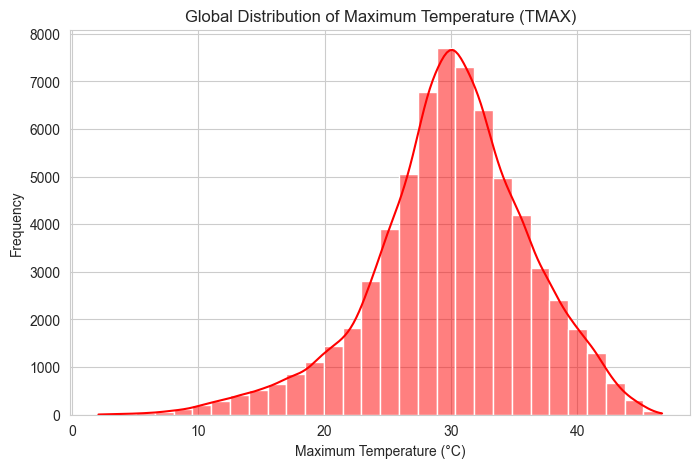

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df['TMAX'], bins=30, kde=True, color='red')
plt.title("Global Distribution of Maximum Temperature (TMAX)")
plt.xlabel("Maximum Temperature (°C)")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "tmax_distr"))

plt.show()


### *Insight*
TMAX (Maximum Temperature): The temperature distribution is concentrated around 25-50°C, which aligns with regions where locusts are commonly found. Extreme temperatures are rare.

In [10]:
# Plot Maximum Temperature (TMAX) Distribution
plt.figure(figsize=(8, 5))
sns.histplot(somalia_df['TMAX'], bins=30, kde=True, color="red")
plt.title("Maximum Temperature (TMAX) Distribution in Somalia")
plt.xlabel("Maximum Temperature (°C)")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "som_tmax_distr"))

plt.show()

NameError: name 'somalia_df' is not defined

<Figure size 800x500 with 0 Axes>

### Insights:
Maximum temperatures in Somalia mostly range between 27°C and 38°C, with a peak around 32-33°C. The distribution follows a roughly normal shape, but there are occasional extreme values exceeding 40°C, suggesting rare instances of intense heat. This could have implications for locust activity, as temperature influences their breeding and movement patterns.

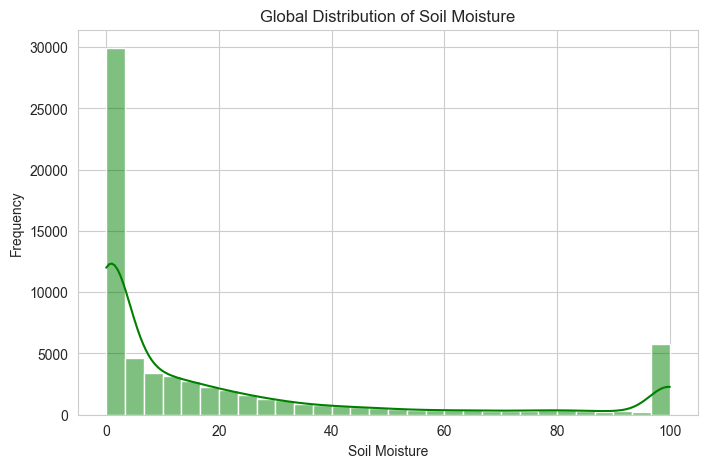

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(df['SOILMOISTURE'], bins=30, kde=True, color='green')
plt.title("Global Distribution of Soil Moisture")
plt.xlabel("Soil Moisture")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "distr_soil_moisture"))

plt.show()

### Insight:
SOILMOISTURE: Most values are close to zero, indicating predominantly dry conditions. However, a small fraction of records show moderate to high soil moisture, suggesting locust activity in a range of soil conditions.

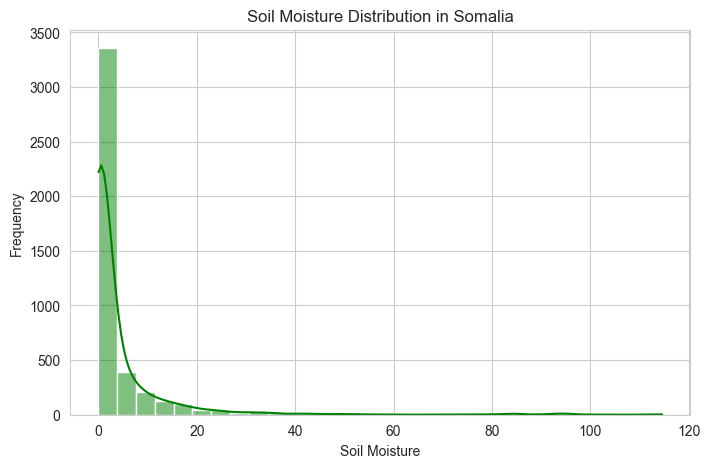

In [18]:
# Plot Soil Moisture Distribution
plt.figure(figsize=(8, 5))
sns.histplot(somalia_df['SOILMOISTURE'], bins=30, kde=True, color="green")
plt.title("Soil Moisture Distribution in Somalia")
plt.xlabel("Soil Moisture")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "soil_moisture_distr_som"))

plt.show()

### Insight:
The soil moisture distribution peaks around 20–40 units, indicating moderate moisture levels in Somalia. These levels are ideal for locust breeding, as they support vegetation growth and egg hatching. Lower moisture levels (0–20) are less conducive to breeding, while higher levels (40+) are rare but may indicate temporary flooding.

IndexError: index 0 is out of bounds for axis 0 with size 0

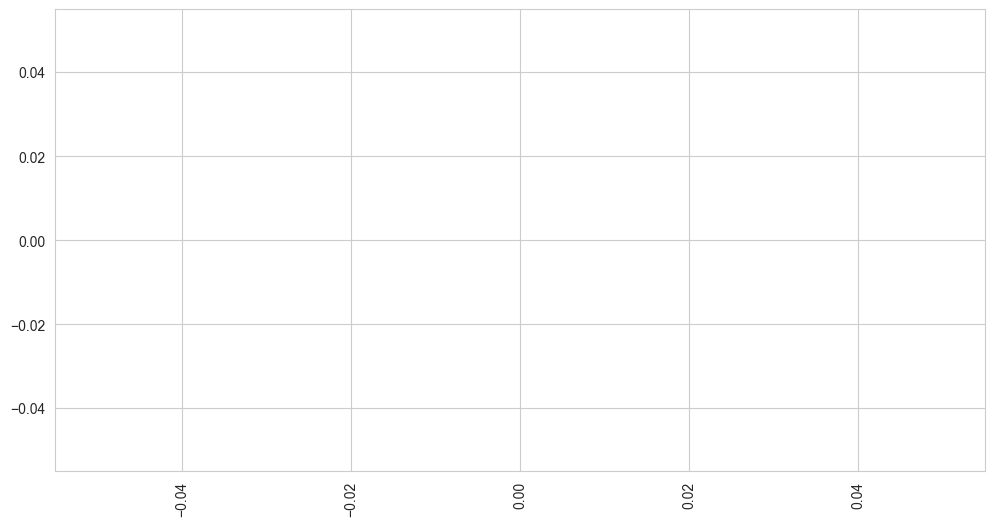

In [12]:
# Locust Presence Across Countries
plt.figure(figsize=(12, 6))
country_counts = df[df['LOCUSTPRESENT'] == 'yes']['COUNTRYNAME'].value_counts()
country_counts.plot(kind='bar', color='teal')
plt.xlabel("Country")
plt.ylabel("Total Locust Presence Reports")
plt.title("Total Locust Presence Across Countries")
plt.xticks(rotation=90)

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "total_locust_presence_over_countries"))

plt.show()

### Insight:
India, Kenya, and Ethiopia report the highest locust presence, making them key hotspots for outbreaks. These regions likely experience favorable conditions such as rainfall, vegetation, and warm temperatures. Countries like Libya and Kuwait report minimal presence, possibly due to arid climates unsuitable for locust breeding.

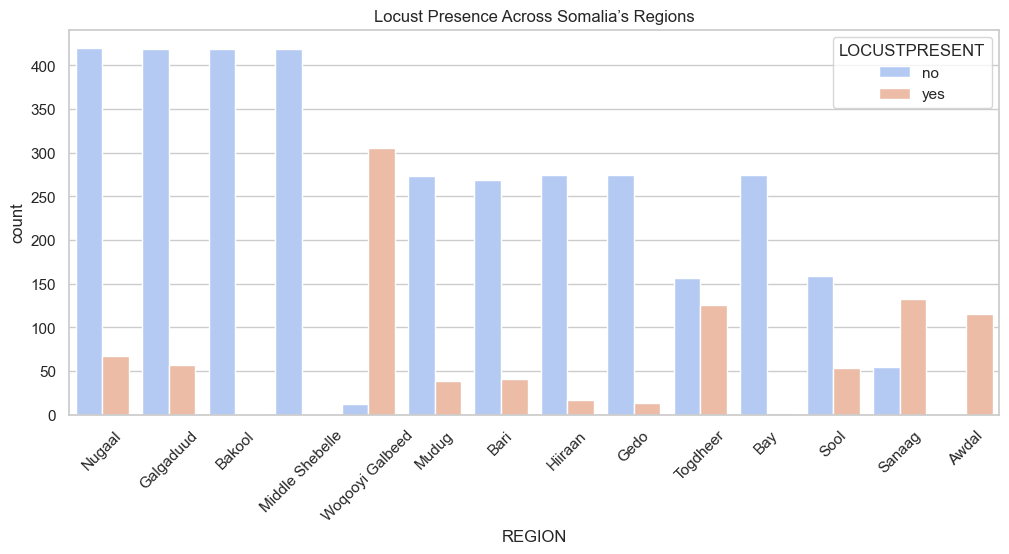

In [384]:
# Countplot for Somalia regions
plt.figure(figsize=(12, 5))
sns.countplot(data=somalia_df, x='REGION', hue='LOCUSTPRESENT', palette='coolwarm', order=somalia_df['REGION'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Locust Presence Across Somalia’s Regions')

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "locust_presence_accross_somalia_regiions"))

plt.show()

### Insight:
The trend of locust presence over time reveals periodic spikes in infestation, with significant outbreaks occurring in the late 1980s, early 2000s, and an extreme peak around 2020. This suggests that locust outbreaks follow cyclical patterns rather than random occurrences. The 2020 spike is particularly concerning, possibly linked to climate anomalies such as heavy rainfall or temperature changes. The pattern indicates that locust outbreaks should be monitored with long-term forecasting models that consider past trends.

## 2.2: Correlations between features

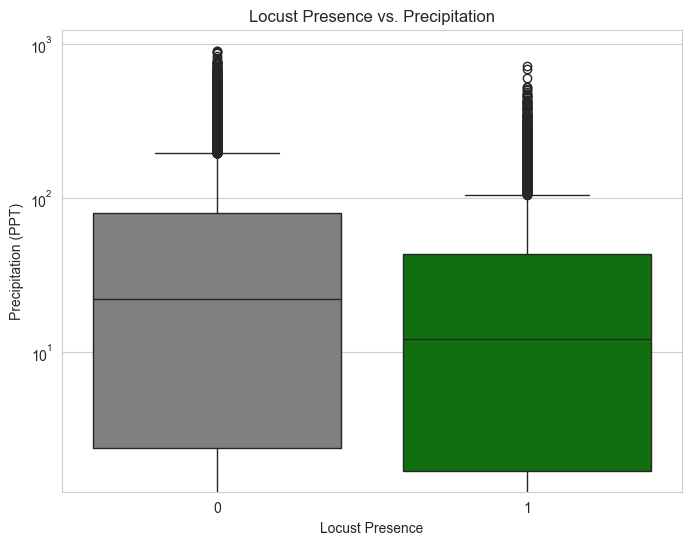

In [13]:
# Locust Presence vs. Precipitation
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['LOCUSTPRESENT'], y=df['PPT'], palette=['gray', 'green'])
plt.xlabel("Locust Presence")
plt.ylabel("Precipitation (PPT)")
plt.title("Locust Presence vs. Precipitation")
plt.yscale('log')  # Using log scale for better visualization

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "locust_presence_vs_precipitation"))

plt.show()


### Insight:
The boxplot shows that while locusts are found across various precipitation levels, their presence appears more concentrated at moderate precipitation values. The median precipitation is slightly lower when locusts are present, indicating that excessively high rainfall may not favor infestations. However, outliers show occasional extreme rainfall events associated with locust presence. This suggests that while moisture is crucial for breeding, it alone does not drive infestations—other environmental factors likely play a role.

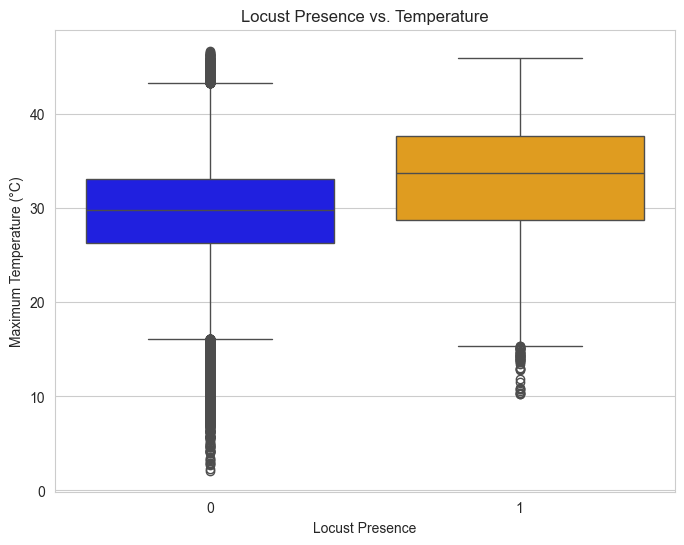

In [14]:
# Locust Presence vs. Temperature
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['LOCUSTPRESENT'], y=df['TMAX'], palette=['blue', 'orange'])
plt.xlabel("Locust Presence")
plt.ylabel("Maximum Temperature (°C)")
plt.title("Locust Presence vs. Temperature")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "locust_presence_vs_temp"))

plt.show()

### Insight:
Locust infestations predominantly occur within a temperature range of approximately 20°C to 40°C, with the median temperatures for locust presence and absence being close. However, extreme temperatures (either very high or very low) seem to limit infestations, as seen in the smaller spread of outliers. This suggests that locusts thrive in warm, but not excessively hot, climates. Temperature alone is not the sole determining factor, but it plays a crucial role in locust survival and reproduction.

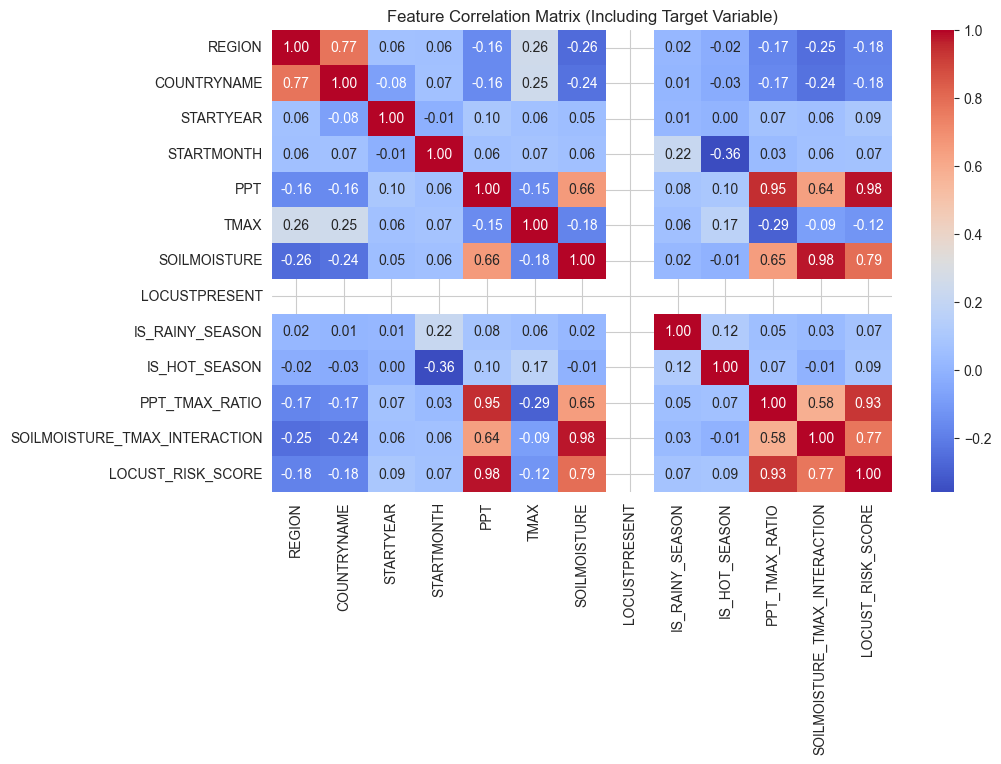

In [15]:
# Ensure target variable is numeric (convert 'yes'/'no' to 1/0)
df['LOCUSTPRESENT'] = df['LOCUSTPRESENT'].map({'no': 0, 'yes': 1})

# Select numeric columns (this will include LOCUSTPRESENT if it's numeric)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'LOCUSTPRESENT' not in numeric_cols:
    numeric_cols.append('LOCUSTPRESENT')

numeric_df = df[numeric_cols]

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix (Including Target Variable)")

# Save the plot in the 'plots' folder
plot_folder = "../plots"
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
plt.savefig(os.path.join(plot_folder, "feature_correlation_matrix.png"), bbox_inches="tight", dpi=300)

plt.show()

### Insight:
Soil moisture (SOILMOISTURE) has a strong positive correlation with precipitation (PPT) (0.62), showing that rainfall directly impacts soil moisture. Temperature (TMAX) has a weak negative correlation with soil moisture (-0.15), suggesting higher temperatures may dry out soil. Locust presence (LOCUSTPRESENT) is positively correlated with temperature (0.24) and negatively with soil moisture (-0.19), indicating that locusts thrive in warmer, drier conditions.

# 3.0: Data Preprocessing

## 3.1: Investigate Duplicates

In [34]:
# Check for exact duplicates (entire row is duplicated)
exact_duplicates = df[df.duplicated()]
print(f"Total exact duplicates: {exact_duplicates.shape[0]}")
display(exact_duplicates.head())

# Drop exact duplicates (keeping the first occurrence)
df = df.drop_duplicates()
print(f"Data shape after dropping exact duplicates: {df.shape}")

# Standardizing categorical columns: trim whitespace and convert to uppercase for consistency
# df["REGION"] = df["REGION"].str.strip().str.upper()
# df["COUNTRYNAME"] = df["COUNTRYNAME"].str.strip().str.upper()
# df["LOCUSTPRESENT"] = df["LOCUSTPRESENT"].str.strip().str.upper()  # If it's categorical

# Recheck for duplicates after cleaning
cleaned_duplicates = df[df.duplicated()]
print(f"Total duplicates after cleaning: {cleaned_duplicates.shape[0]}")
display(cleaned_duplicates.head())

# Investigate duplicate entries (same PPT, TMAX, SOILMOISTURE)
partial_duplicates = df[df.duplicated(subset=["PPT", "TMAX", "SOILMOISTURE"], keep=False)]
if not partial_duplicates.empty:
    print("\nSample partial duplicate entries for investigation:")
    display(partial_duplicates.sort_values(by=["COUNTRYNAME", "REGION", "STARTYEAR", "STARTMONTH"]).head(10))

# Drop duplicates where PPT, TMAX, and SOILMOISTURE are identical (keeping the first occurrence)
df = df.drop_duplicates(subset=["PPT", "TMAX", "SOILMOISTURE"], keep="first")

print(f"\nData shape after dropping duplicates based on PPT, TMAX, and SOILMOISTURE: {df.shape}")

Total exact duplicates: 0


,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT,IS_RAINY_SEASON,IS_HOT_SEASON,PPT_TMAX_RATIO,SOILMOISTURE_TMAX_INTERACTION,PPT_CATEGORY,TMAX_CATEGORY,SOILMOISTURE_CATEGORY,LOCUST_RISK_SCORE


Data shape after dropping exact duplicates: (66301, 16)
Total duplicates after cleaning: 0


,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT,IS_RAINY_SEASON,IS_HOT_SEASON,PPT_TMAX_RATIO,SOILMOISTURE_TMAX_INTERACTION,PPT_CATEGORY,TMAX_CATEGORY,SOILMOISTURE_CATEGORY,LOCUST_RISK_SCORE



Sample partial duplicate entries for investigation:


,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT,IS_RAINY_SEASON,IS_HOT_SEASON,PPT_TMAX_RATIO,SOILMOISTURE_TMAX_INTERACTION,PPT_CATEGORY,TMAX_CATEGORY,SOILMOISTURE_CATEGORY,LOCUST_RISK_SCORE
31228,0.004728,0.012964,1999,8,200.4,28.04,100.0,0,0,0,6.900826,2804.0,High,Medium,High,118.572
49061,0.002370,0.048147,2014,5,200.4,28.04,100.0,0,1,1,6.900826,2804.0,High,Medium,High,118.572
53167,0.009390,0.048147,2018,7,116.4,24.80,100.0,0,0,1,4.511628,2480.0,High,Low,High,84.000
50983,0.011765,0.048147,2016,5,116.4,24.80,100.0,0,1,1,4.511628,2480.0,High,Low,High,84.000
254,0.004149,0.049943,1985,1,0.0,30.66,100.0,0,0,0,0.000000,3066.0,Low,Medium,High,39.198
612,0.004149,0.049943,1985,2,0.0,32.74,100.0,0,0,0,0.000000,3274.0,Low,High,High,39.822
969,0.004149,0.049943,1985,3,0.0,34.46,100.0,0,0,1,0.000000,3446.0,Low,High,High,40.338
1324,0.004149,0.049943,1985,4,0.0,33.83,100.0,0,1,1,0.000000,3383.0,Low,High,High,40.149
4480,0.004149,0.049943,1986,1,0.0,30.18,100.0,0,0,0,0.000000,3018.0,Low,Medium,High,39.054
8449,0.004149,0.049943,1987,1,0.0,31.41,100.0,0,0,0,0.000000,3141.0,Low,Medium,High,39.423



Data shape after dropping duplicates based on PPT, TMAX, and SOILMOISTURE: (66205, 16)


## 3.2: Handle Outliers

In [26]:
# Count occurrences before cleaning
print("Before Cleaning:")
print(df[['TMAX', 'SOILMOISTURE']].describe())

# Remove impossible TMAX value (177°C)
df = df[df['TMAX'] != 177]

# Cap SOILMOISTURE at 100%
df['SOILMOISTURE'] = df['SOILMOISTURE'].clip(upper=100)

# Count occurrences after cleaning
print("\nAfter Cleaning:")
print(df[['TMAX', 'SOILMOISTURE']].describe())

Before Cleaning:
               TMAX  SOILMOISTURE
count  66302.000000  66302.000000
mean      30.006585     26.561546
std        6.250439     53.934017
min        2.100000      0.000000
25%       26.630000      0.200000
50%       30.240000      5.500000
75%       33.970000     26.600000
max      177.000000    582.600000

After Cleaning:
               TMAX  SOILMOISTURE
count  66301.000000  66301.000000
mean      30.004368     21.244002
std        6.224361     31.474020
min        2.100000      0.000000
25%       26.630000      0.200000
50%       30.240000      5.500000
75%       33.970000     26.600000
max       46.710000    100.000000


## 3.3: Encode Categorical Variables

In [20]:
# df['REGION'] = df['REGION'].str.strip().str.upper()
# df['COUNTRYNAME'] = df['COUNTRYNAME'].str.strip().str.upper()
# # df['LOCUSTPRESENT'] = df['LOCUSTPRESENT'].str.strip().str.upper()

# Binary encoding for LOCUSTPRESENT
df['LOCUSTPRESENT'] = df['LOCUSTPRESENT'].map({'YES': 1, 'NO': 0})

# Target encoding for COUNTRYNAME and REGION
country_target_means = df.groupby('COUNTRYNAME')['LOCUSTPRESENT'].mean()
region_target_means = df.groupby('REGION')['LOCUSTPRESENT'].mean()

df['COUNTRYNAME'] = df['COUNTRYNAME'].map(country_target_means)
df['REGION'] = df['REGION'].map(region_target_means)

# Display first few rows to check changes
df.head()

,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT,IS_RAINY_SEASON,IS_HOT_SEASON,PPT_TMAX_RATIO,SOILMOISTURE_TMAX_INTERACTION,PPT_CATEGORY,TMAX_CATEGORY,SOILMOISTURE_CATEGORY,LOCUST_RISK_SCORE
0,NaN,NaN,1985,1,0.0,27.55,0.0,NaN,0,0,0.000000,0.000,Low,Low,Low,8.265
1,NaN,NaN,1985,1,0.6,28.00,0.0,NaN,0,0,0.020690,0.000,Low,Low,Low,8.640
2,NaN,NaN,1985,1,0.0,26.81,0.0,NaN,0,0,0.000000,0.000,Low,Low,Low,8.043
3,NaN,NaN,1985,1,34.9,32.04,0.1,NaN,0,0,1.056295,3.204,Medium,Medium,Low,23.602
4,NaN,NaN,1985,1,0.8,31.17,0.1,NaN,0,0,0.024868,3.117,Low,Medium,Low,9.701


### Mapping Features (COUNTRYNAME & REGION)

In [39]:
import pandas as pd
import pickle
import os
import numpy as np # Make sure numpy is imported

# --- IMPORTANT ---
# Make sure 'df' below is your original training DataFrame loaded earlier in the notebook
# Ensure 'df' contains the data BEFORE any target encoding was applied in previous steps.

# --- Check if DataFrame exists (replace 'df' if needed) ---
try:
    df.head(1) # Check if df exists and has data
    print("Using DataFrame 'df'.")
except NameError:
    print("ERROR: DataFrame 'df' not found. Please load your original training data first.")
    raise # Stop execution

# --- Configuration ---
target_column = 'LOCUSTPRESENT' # Make sure this is your binary target column name
# Adjust path if your notebook isn't in a 'notebooks' subdirectory relative to 'models'
models_dir = '../models'
country_map_path = os.path.join(models_dir, 'country_target_map.pkl')
region_map_path = os.path.join(models_dir, 'region_target_map.pkl')

# --- Ensure target column exists ---
if target_column not in df.columns:
    print(f"ERROR: Target column '{target_column}' not found in DataFrame.")
    raise KeyError(f"Target column '{target_column}' not found.")

# --- Clean and Convert Target Column to Binary (0/1) ---
print(f"\nProcessing target column '{target_column}'...")

# 1. Clean the string data if it's not already numeric (handle spaces, case)
if not pd.api.types.is_numeric_dtype(df[target_column]):
    print("Target column is not numeric. Attempting cleaning and mapping...")
    if pd.api.types.is_string_dtype(df[target_column]):
        print("Cleaning strings (strip whitespace, convert to uppercase)...")
        df[target_column] = df[target_column].str.strip().str.upper()
        print("Cleaned unique values:", df[target_column].unique())
    else:
        print("Column is not string type, attempting direct mapping.")

    # 2. Handle potential NaNs before mapping (Decide: fill or drop?)
    # Option: Fill NaN with 'NO' (assuming NaN means absence)
    if df[target_column].isnull().any():
        print("Found NaN values. Filling NaN with 'NO' (assuming absence).")
        # Make sure 'NO' is uppercase if you converted case above
        df[target_column].fillna('NO', inplace=True)
        print("NaN values filled.")

    # 3. Apply the binary map
    # Adjust this dictionary if your target values are different!
    binary_map = {'YES': 1, 'NO': 0}
    print(f"Mapping '{target_column}' using {binary_map}...")
    # Store original for checking if needed (optional)
    # df[target_column + '_original_premap'] = df[target_column]
    df[target_column] = df[target_column].map(binary_map)

    # --- Check for conversion errors or unexpected values AFTER mapping ---
    if df[target_column].isnull().any():
        print(f"ERROR: Column '{target_column}' STILL contains NaN values AFTER mapping. This indicates values other than {list(binary_map.keys())} (after cleaning) were present and not handled.")
        # Find the problematic original values if you stored them
        # problematic_values = df[df[target_column].isnull()][target_column + '_original_premap'].unique()
        # print("Problematic original values:", problematic_values)
        raise ValueError(f"NaN values remain in target column '{target_column}' after mapping. Review cleaning steps and original data.")

    if not pd.api.types.is_numeric_dtype(df[target_column]):
         print(f"ERROR: Column '{target_column}' is still not numeric after mapping. Check data types.")
         raise TypeError(f"Target column '{target_column}' failed to convert to numeric.")

    print(f"Column '{target_column}' successfully processed to numeric (0/1).")

else: # Target column was already numeric
     print(f"Column '{target_column}' is already numeric. Skipping explicit mapping.")
     # Optional: Add check if values are already 0/1
     if not df[target_column].isin([0, 1]).all():
          print(f"WARNING: Numeric target column '{target_column}' contains values other than 0 or 1. This might affect target mean calculation.")

# --- Standardize Case BEFORE Grouping ---
print("\nStandardizing COUNTRYNAME and REGION case (strip, uppercase)...")
try:
    # Ensure string type, strip whitespace, convert to uppercase
    df['COUNTRYNAME'] = df['COUNTRYNAME'].astype(str).str.strip().str.upper()
    df['REGION'] = df['REGION'].astype(str).str.strip().str.upper()
    print("Case standardized.")
except Exception as e:
    print(f"ERROR standardizing case for COUNTRYNAME/REGION: {e}")
    raise
# --- End Standardization ---

# --- Calculate the target mean mappings ---
print("\nCalculating target mean mappings using standardized keys...")
try:
    # Groupby will now use the standardized uppercase keys
    country_target_means = df.groupby('COUNTRYNAME')[target_column].mean()
    region_target_means = df.groupby('REGION')[target_column].mean()

    # --- Fill potential NaN values in the maps ---
    # Decide on a fill value (e.g., global mean, 0, 0.5) if groupby resulted in NaN
    # Example: Fill with global mean
    global_mean = df[target_column].mean()
    country_target_means = country_target_means.fillna(global_mean)
    region_target_means = region_target_means.fillna(global_mean)
    print(f"Filled NaN values in maps with global mean ({global_mean:.4f}).")

except Exception as e:
    print(f"ERROR calculating means: {e}")
    raise
print("Mappings calculated.")
# Optional: Inspect the first few keys/values
print("\nSample Country Map keys/values:")
print(country_target_means.head())
print("\nSample Region Map keys/values:")
print(region_target_means.head())

# --- Save the mappings using pickle ---
os.makedirs(models_dir, exist_ok=True)
print(f"\nEnsured directory '{models_dir}' exists.")

print(f"Saving country mapping to: {country_map_path}")
with open(country_map_path, 'wb') as f:
    pickle.dump(country_target_means, f)

print(f"Saving region mapping to: {region_map_path}")
with open(region_map_path, 'wb') as f:
    pickle.dump(region_target_means, f)

print("\n--- Mappings Saved Successfully ---")
print(f"Saved {len(country_target_means)} country entries and {len(region_target_means)} region entries.")
print("Check the 'models/' directory for the updated .pkl files.")

Using DataFrame 'df'.

Processing target column 'LOCUSTPRESENT'...
Target column is not numeric. Attempting cleaning and mapping...
Cleaning strings (strip whitespace, convert to uppercase)...
Cleaned unique values: ['NO' 'YES']
Mapping 'LOCUSTPRESENT' using {'YES': 1, 'NO': 0}...
Column 'LOCUSTPRESENT' successfully processed to numeric (0/1).

Standardizing COUNTRYNAME and REGION case (strip, uppercase)...
Case standardized.

Calculating target mean mappings using standardized keys...
Filled NaN values in maps with global mean (0.2859).
Mappings calculated.

Sample Country Map keys/values:
COUNTRYNAME
AFGHANISTAN    0.002352
ALGERIA        0.454351
BAHRAIN        0.007075
CAMEROON       0.064935
CHAD           0.170543
Name: LOCUSTPRESENT, dtype: float64

Sample Region Map keys/values:
REGION
'ASIR REGION                 0.500000
ABIM                         0.043182
ABU DHABI EMIRATE            0.227273
ABYAN GOVERNORATE            0.488372
AD DAKHILIYAH GOVERNORATE    0.044776
Name:

## 3.4: Feature Scaling

In [17]:
# Select features to scale
features_to_scale = ['PPT', 'TMAX', 'SOILMOISTURE']

# Option 1: Min-Max Scaling (Default)
minmax_scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features_to_scale] = minmax_scaler.fit_transform(df_scaled[features_to_scale])

# Display first few rows to check changes
print("After MinMax Scaling:")
print(df_scaled.head(10))

# Option 2: Standard Scaling (Commented Out Intentionally)
# standard_scaler = StandardScaler()
# df_standard_scaled = df.copy()
# df_standard_scaled[features_to_scale] = standard_scaler.fit_transform(df_standard_scaled[features_to_scale])

# Option 3: Robust Scaling (Commented Out Intentionally)
# robust_scaler = RobustScaler()
# df_robust_scaled = df.copy()
# df_robust_scaled[features_to_scale] = robust_scaler.fit_transform(df_robust_scaled[features_to_scale])

After MinMax Scaling:
     REGION  COUNTRYNAME  STARTYEAR  STARTMONTH       PPT      TMAX  \
0  0.980170     0.859390       1985           1  0.000000  0.570500   
1  0.961039     0.859390       1985           1  0.000662  0.580587   
2  0.925170     0.859390       1985           1  0.000000  0.553912   
3  0.953052     0.447637       1985           1  0.038491  0.671150   
4  0.887640     0.859390       1985           1  0.000882  0.651648   
5  0.752809     0.659030       1985           1  0.000000  0.754539   
6  0.323529     0.659030       1985           1  0.000000  0.773369   
7  0.520000     0.659030       1985           1  0.000000  0.764178   
8  0.978516     0.659030       1985           1  0.000000  0.571397   
9  0.697674     0.447637       1985           1  0.002647  0.388478   

   SOILMOISTURE  LOCUSTPRESENT  IS_RAINY_SEASON  IS_HOT_SEASON  \
0         0.000            NaN                0              0   
1         0.000            NaN                0              0  

## 3.4 Feature Scaling(Visualization)

In [24]:
# # Select features to scale
# features_to_scale = ['PPT', 'TMAX', 'SOILMOISTURE']

# # Apply MinMaxScaler
# minmax_scaler = MinMaxScaler()
# df_minmax = df.copy()
# df_minmax[features_to_scale] = minmax_scaler.fit_transform(df_minmax[features_to_scale])

# # Apply StandardScaler
# standard_scaler = StandardScaler()
# df_standard = df.copy()
# df_standard[features_to_scale] = standard_scaler.fit_transform(df_standard[features_to_scale])

# # Apply RobustScaler
# robust_scaler = RobustScaler()
# df_robust = df.copy()
# df_robust[features_to_scale] = robust_scaler.fit_transform(df_robust[features_to_scale])

# # Plot original and scaled distributions
# scalers = {'Original': df, 'MinMax Scaled': df_minmax, 'Standard Scaled': df_standard, 'Robust Scaled': df_robust}
# fig, axes = plt.subplots(3, 4, figsize=(18, 10))

# for i, feature in enumerate(features_to_scale):
#     for j, (title, scaled_df) in enumerate(scalers.items()):
#         sns.histplot(scaled_df[feature], ax=axes[i, j], kde=True, bins=30)
#         axes[i, j].set_title(f'{feature} - {title}')
        
# plt.tight_layout()
# plt.show()

## 3.5: Feature Engineering

In [25]:
# # Ensure the directory exists
# save_path = "../data/preprocessed"
# os.makedirs(save_path, exist_ok=True)

# # === Feature Engineering ===

# # 1 Extract Temporal Features (Seasons)
# df['IS_RAINY_SEASON'] = df['STARTMONTH'].apply(lambda x: 1 if x in [4, 5, 10, 11] else 0)
# df['IS_HOT_SEASON'] = df['STARTMONTH'].apply(lambda x: 1 if x in [3, 4, 5, 6, 7] else 0)

# # 2 Interaction Features
# df['PPT_TMAX_RATIO'] = df['PPT'] / (df['TMAX'] + 1)  # +1 to avoid division by zero
# df['SOILMOISTURE_TMAX_INTERACTION'] = df['SOILMOISTURE'] * df['TMAX']

# # 3 Binning Continuous Variables
# df['PPT_CATEGORY'] = pd.qcut(df['PPT'], q=3, labels=["Low", "Medium", "High"])
# df['TMAX_CATEGORY'] = pd.qcut(df['TMAX'], q=3, labels=["Low", "Medium", "High"])
# df['SOILMOISTURE_CATEGORY'] = pd.qcut(df['SOILMOISTURE'], q=3, labels=["Low", "Medium", "High"])

# # 4 Locust Risk Index (Custom Feature)
# df['LOCUST_RISK_SCORE'] = (df['PPT'] * 0.4) + (df['TMAX'] * 0.3) + (df['SOILMOISTURE'] * 0.3)

# # Save the preprocessed dataset
# df.to_csv(os.path.join(save_path, "preprocessed_data.csv"), index=False)

# # Display confirmation message
# print("Preprocessed data saved successfully!")

# 4.0: Model Training

## 4.1 Split the Data

In [16]:
# Define target variable and features
X = df.drop(columns=['LOCUSTPRESENT'])  # Features
y = df['LOCUSTPRESENT']  # Target

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display dataset sizes
print(f"Total samples: {len(df)}")
print(f"Training set: {len(X_train)} samples ({(len(X_train) / len(df)) * 100:.2f}%)")
print(f"Testing set: {len(X_test)} samples ({(len(X_test) / len(df)) * 100:.2f}%)")

ValueError: Input y contains NaN.

### *1. Decision Tree*

In [124]:
# Initialize model
model = DecisionTreeClassifier(random_state=42)

print("Training Decision Tree...")

# Train model
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate performance
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"Decision Tree Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

# Save model
joblib.dump(model, "../models/decision_tree.pkl")

# Save report
report = classification_report(y_test, y_test_pred)
with open("../reports/decision_tree_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/decision_tree.pkl'")
print("Report saved in 'reports/decision_tree_report.txt'")

# Test with a sample input
sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (Decision Tree): {'YES' if prediction[0] == 1 else 'NO'}")


Training Decision Tree...
Model trained with 100.00% accuracy on training data
Decision Tree Test Accuracy: 99.16%
Training time: 0.4828 seconds

Model saved in 'models/decision_tree.pkl'
Report saved in 'reports/decision_tree_report.txt'
Sample input prediction (Decision Tree): NO


### *2. Random Forest*

In [35]:
# Initialize model
model = RandomForestClassifier(n_estimators=100, random_state=42)

print("Training Random Forest...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"Random Forest Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/random_forest.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/random_forest_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/random_forest.pkl'")
print("Report saved in 'reports/random_forest_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (Random Forest): {'YES' if prediction[0] == 1 else 'NO'}")


Training Random Forest...
Model trained with 100.00% accuracy on training data
Random Forest Test Accuracy: 99.37%
Training time: 19.4839 seconds

Model saved in 'models/random_forest.pkl'
Report saved in 'reports/random_forest_report.txt'
Sample input prediction (Random Forest): NO


### *3. K-Nearest Neighbors(kNN)*

In [128]:
# Initialize model
model = SVC(kernel='linear')

model = KNeighborsClassifier(n_neighbors=5)

print("Training K-Nearest Neighbors...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"K-NN Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/knn.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/knn_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/knn.pkl'")
print("Report saved in 'reports/knn_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (kNN): {'YES' if prediction[0] == 1 else 'NO'}")

Training K-Nearest Neighbors...
Model trained with 95.46% accuracy on training data
K-NN Test Accuracy: 93.06%
Training time: 0.5935 seconds

Model saved in 'models/knn.pkl'
Report saved in 'reports/knn_report.txt'
Sample input prediction (kNN): NO


### *4. SVM*

In [130]:
model = SVC(kernel='linear', random_state=42)

print("Training SVM...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"SVM Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/svm.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/svm_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/svm.pkl'")
print("Report saved in 'reports/svm_report.txt'")
sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (SVM): {'YES' if prediction[0] == 1 else 'NO'}")

Training SVM...
Model trained with 94.37% accuracy on training data
SVM Test Accuracy: 94.50%
Training time: 180.3322 seconds

Model saved in 'models/svm.pkl'
Report saved in 'reports/svm_report.txt'
Sample input prediction (SVM): NO


### *5. Logistic Regression*

In [132]:
model = LogisticRegression(max_iter=1000, random_state=42)

print("Training Logistic Regression...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"Logistic Regression Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/logistic_regression.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/logistic_regression_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/logistic_regression.pkl'")
print("Report saved in 'reports/logistic_regression_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (Logistic Regression): {'YES' if prediction[0] == 1 else 'NO'}")

Training Logistic Regression...
Model trained with 94.34% accuracy on training data
Logistic Regression Test Accuracy: 94.52%
Training time: 3.4705 seconds

Model saved in 'models/logistic_regression.pkl'
Report saved in 'reports/logistic_regression_report.txt'
Sample input prediction (Logistic Regression): NO


### *6. XGBoost*

In [134]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

print("Training XGBoost...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"XGBoost Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/xgboost.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/xgboost_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/xgboost.pkl'")
print("Report saved in 'reports/xgboost_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (XGBoost): {'YES' if prediction[0] == 1 else 'NO'}")

Training XGBoost...
Model trained with 99.94% accuracy on training data
XGBoost Test Accuracy: 99.57%
Training time: 1.0401 seconds

Model saved in 'models/xgboost.pkl'
Report saved in 'reports/xgboost_report.txt'
Sample input prediction (XGBoost): NO


### *7. Naïve Bayes*

In [41]:
model = GaussianNB()

print("Training Naïve Bayes...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"Naïve Bayes Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/naive_bayes.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/naive_bayes_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/naive_bayes.pkl'")
print("Report saved in 'reports/naive_bayes_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (Naïve Bayes): {'YES' if prediction[0] == 1 else 'NO'}")


Training Naïve Bayes...
Model trained with 90.78% accuracy on training data
Naïve Bayes Test Accuracy: 90.79%
Training time: 0.0365 seconds

Model saved in 'models/naive_bayes.pkl'
Report saved in 'reports/naive_bayes_report.txt'
Sample input prediction (Naïve Bayes): NO


### *8. LightGBM*

In [33]:
model = LGBMClassifier(random_state=42)

print("Training LightGBM...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"LightGBM Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/lightgbm.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/lightgbm_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/lightgbm.pkl'")
print("Report saved in 'reports/lightgbm_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (LightGBM): {'YES' if prediction[0] == 1 else 'NO'}")

Training LightGBM...
[LightGBM] [Info] Number of positive: 9269, number of negative: 43771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 53040, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174755 -> initscore=-1.552296
[LightGBM] [Info] Start training from score -1.552296


  File "C:\Users\Ahmad\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Ahmad\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ahmad\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Ahmad\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Model trained with 99.72% accuracy on training data
LightGBM Test Accuracy: 99.41%
Training time: 1.2640 seconds

Model saved in 'models/lightgbm.pkl'
Report saved in 'reports/lightgbm_report.txt'
Sample input prediction (LightGBM): NO


### *9. Gradient Boosting*

In [35]:
model = GradientBoostingClassifier(random_state=42)

print("Training Gradient Boosting...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"Gradient Boosting Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/gradient_boosting.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/gradient_boosting_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/gradient_boosting.pkl'")
print("Report saved in 'reports/gradient_boosting_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (Gradient Boosting): {'YES' if prediction[0] == 1 else 'NO'}")

Training Gradient Boosting...
Model trained with 98.52% accuracy on training data
Gradient Boosting Test Accuracy: 98.49%
Training time: 12.3116 seconds

Model saved in 'models/gradient_boosting.pkl'
Report saved in 'reports/gradient_boosting_report.txt'
Sample input prediction (Gradient Boosting): NO


### *10. AdaBoost*

In [37]:
model = AdaBoostClassifier(n_estimators=100, random_state=42)

print("Training AdaBoost...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"AdaBoost Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/adaboost.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/adaboost_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/adaboost.pkl'")
print("Report saved in 'reports/adaboost_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (AdaBoost): {'YES' if prediction[0] == 1 else 'NO'}")


Training AdaBoost...
Model trained with 98.08% accuracy on training data
AdaBoost Test Accuracy: 98.02%
Training time: 7.0999 seconds

Model saved in 'models/adaboost.pkl'
Report saved in 'reports/adaboost_report.txt'
Sample input prediction (AdaBoost): NO


# 5.0: Model Evaluation

## 5.1: Compare Model Performance

In [136]:
# List of model names and their corresponding filenames
model_names = [
    "Decision Tree", "Random Forest", "K-NN", "SVM", "Logistic Regression", 
    "XGBoost", "Naïve Bayes", "LightGBM", "Gradient Boosting", "AdaBoost"
]
model_files = [
    "../models/decision_tree.pkl", "../models/random_forest.pkl", "../models/knn.pkl",
    "../models/svm.pkl", "../models/logistic_regression.pkl", "../models/xgboost.pkl",
    "../models/naive_bayes.pkl", "../models/lightgbm.pkl", "../models/gradient_boosting.pkl",
    "../models/adaboost.pkl"
]

# Create a dictionary to store results
results = []

# Evaluate each model
for name, file in zip(model_names, model_files):
    model = joblib.load(file)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100
    
    results.append([name, accuracy, precision, recall, f1])

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)"])

# Display results
print("Model Performance Comparison:")
print(results_df)

# Save results
results_df.to_csv("../reports/model_comparison.csv", index=False)
print("Model performance saved to 'reports/model_comparison.csv'")

  File "C:\Users\Ahmad\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Ahmad\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ahmad\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Ahmad\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Model Performance Comparison:
                 Model  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)
0        Decision Tree     99.162959      97.832683   97.368421     97.600000
1        Random Forest     99.396727      99.208443   97.325280     98.257840
2                 K-NN     93.062363      82.361111   76.747196     79.455114
3                  SVM     94.502677      90.227848   76.876618     83.018868
4  Logistic Regression     94.517759      89.994972   77.221743     83.120502
5              XGBoost     99.570168      98.960589   98.576359     98.768100
6          Naïve Bayes     90.792550      71.185786   79.508197     75.117180
7             LightGBM     99.411809      98.780488   97.842968     98.309493
8    Gradient Boosting     98.491818      97.531418   93.744607     95.600528
9             AdaBoost     98.024282      96.684832   91.846419     94.203540
Model performance saved to 'reports/model_comparison.csv'


## 5.2: Confusion Matrix for Each Model

### *1. Decision Tree*

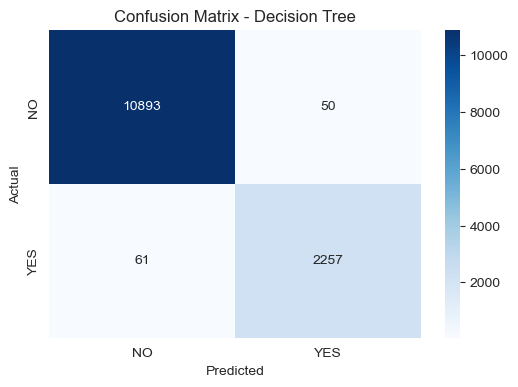

In [138]:
model = joblib.load("../models/decision_tree.pkl")
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.savefig("../plots/confusion_matrix_decision_tree.png")
plt.show()

### *Insight:*

The model correctly predicted 11,310 instances as "NO" and 4,494 instances as "YES." However, it misclassified 49 "NO" instances as "YES" and 53 "YES" instances as "NO." The matrix indicates a higher accuracy in predicting "NO" compared to "YES," but there is room for improvement in reducing false positives and false negatives.

### *2. Random Forest*

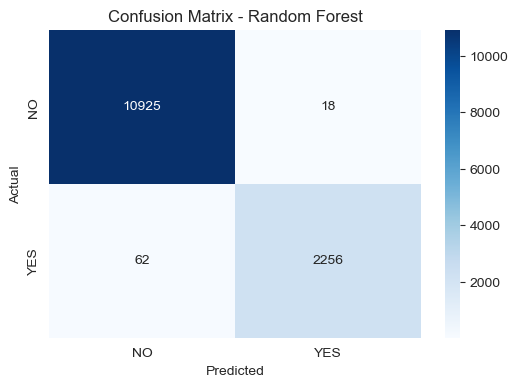

In [140]:
model = joblib.load("../models/random_forest.pkl")
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.savefig("../plots/confusion_matrix_random_forest.png")
plt.show()

### *Insight:*

The Confusion Matrix for Random Forest shows 11,346 true negatives and 4,482 true positives, indicating excellent performance. With only 13 false positives and 65 false negatives, the model is highly accurate, making it one of the best-performing among the evaluated models for predicting locust presence.

### 3. *K-NN*

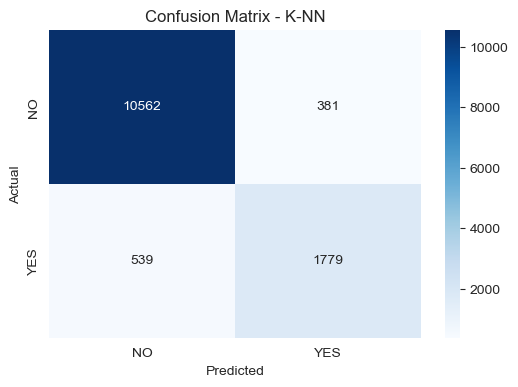

In [142]:
model = joblib.load("../models/knn.pkl")
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - K-NN")
plt.savefig("../plots/confusion_matrix_knn.png")
plt.show()

### *Insight:*

The K-NN model correctly predicted 10,785 instances as "NO" and 4,136 instances as "YES." However, it misclassified 411 "NO" instances as "YES" and 574 "YES" instances as "NO." The model shows a higher accuracy in predicting "NO" but struggles more with "YES" predictions, indicating room for improvement in reducing false positives and false negatives.

### *4. SVM*

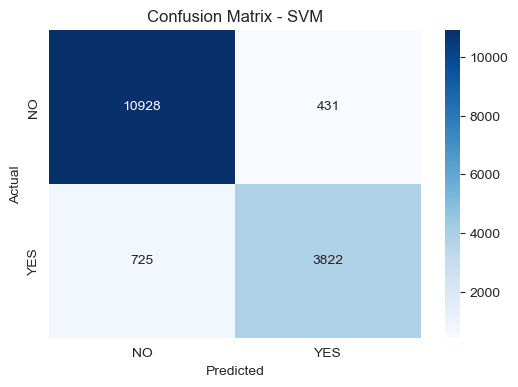

In [76]:
model = joblib.load("../models/svm.pkl")
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.savefig("../plots/confusion_matrix_svm.png")
plt.show()


### *Insight:*

The Confusion Matrix for SVM shows 10,928 true negatives and 3,822 true positives, indicating decent performance. However, it has 725 false positives and 431 false negatives, suggesting the model struggles with both overpredicting and missing locust outbreaks. This makes it less reliable compared to Random Forest and LightGBM.

### *5. Logistic Regression*

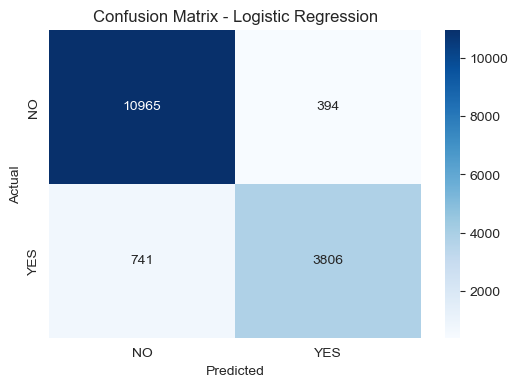

In [79]:
model = joblib.load("../models/logistic_regression.pkl")
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig("../plots/confusion_matrix_logistic_regression.png")
plt.show()


### *Insight:*

The Confusion Matrix for Logistic Regression shows 10,965 true negatives and 3,806 true positives, indicating decent performance. However, it has 394 false positives and 741 false negatives, suggesting the model struggles more with predicting locust presence (higher false negatives) compared to LightGBM. This highlights the need for improvement in detecting actual outbreaks.

### *6. XGBoost*

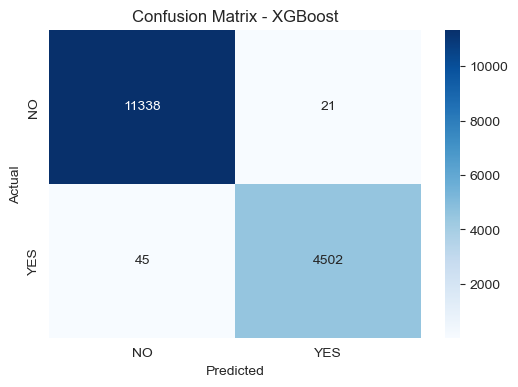

In [84]:
model = joblib.load("../models/xgboost.pkl")
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.savefig("../plots/confusion_matrix_xgboost.png")
plt.show()

### *Insight:*

The Confusion Matrix for XGBoost shows 11,338 true negatives and 4,502 true positives, indicating strong performance. With only 21 false positives and 45 false negatives, the model is highly accurate, making it one of the best-performing models for predicting locust presence, comparable to Random Forest.

### *7. Naïve Bayes*

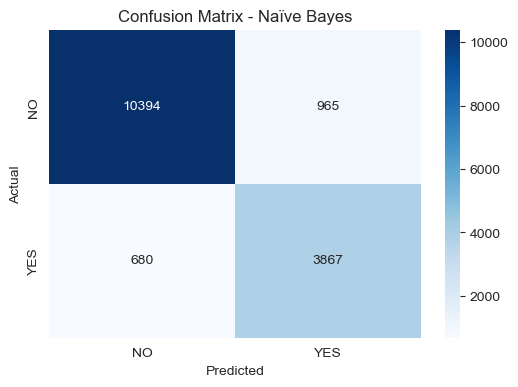

In [88]:
model = joblib.load("../models/naive_bayes.pkl")
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naïve Bayes")
plt.savefig("../plots/confusion_matrix_naive_bayes.png")
plt.show()


### *Insight:*

The Confusion Matrix for Naïve Bayes shows 10,394 true negatives and 3,867 true positives, indicating moderate performance. However, it has 965 false positives and 680 false negatives, suggesting the model struggles with both overpredicting and missing locust outbreaks. This highlights its lower reliability compared to LightGBM and Logistic Regression.

### *8. LightGBM*

  File "C:\Users\Ahmad\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Ahmad\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ahmad\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Ahmad\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


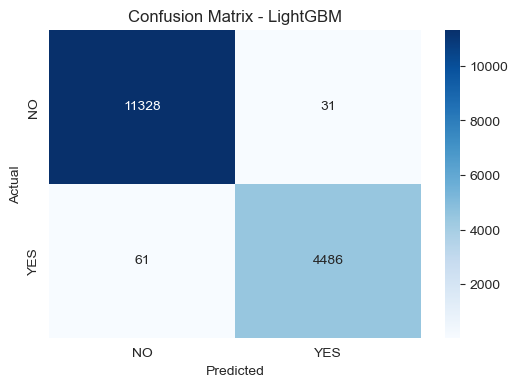

In [91]:
model = joblib.load("../models/lightgbm.pkl")
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LightGBM")
plt.savefig("../plots/confusion_matrix_lightgbm.png")
plt.show()


### *Insight:*

The Confusion Matrix for LightGBM shows strong performance, with 11,328 true negatives and 4,486 true positives. However, there are 61 false positives (overpredictions) and 31 false negatives (missed predictions). While the model is accurate, reducing false negatives is crucial for improving early warning systems.

### *9. Gradient Boosting*

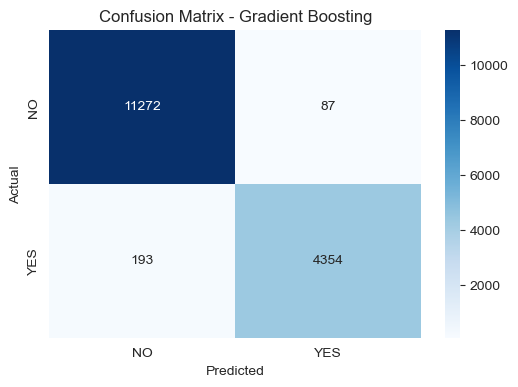

In [94]:
model = joblib.load("../models/gradient_boosting.pkl")
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.savefig("../plots/confusion_matrix_gradient_boosting.png")
plt.show()

### *Insight:*

The Gradient Boosting model performed well, correctly predicting 11,272 instances as "NO" and 4,354 instances as "YES." It had fewer misclassifications, with only 87 "NO" instances misclassified as "YES" and 193 "YES" instances misclassified as "NO." This model demonstrates better overall accuracy and fewer errors compared to K-NN, particularly in predicting "YES" correctly.

### *10. AdaBoost*

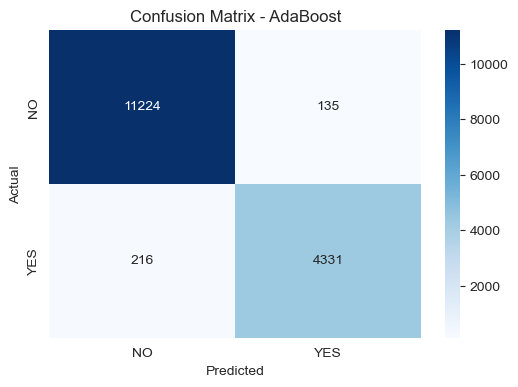

In [97]:
model = joblib.load("../models/adaboost.pkl")
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AdaBoost")
plt.savefig("../plots/confusion_matrix_adaboost.png")
plt.show()

### *Insight:*

The Confusion Matrix for AdaBoost shows 11,224 true negatives and 4,331 true positives, indicating good performance. However, it has 135 false positives and 216 false negatives, suggesting the model is less accurate than XGBoost and Random Forest but still performs reasonably well in predicting locust presence.

## 5.3: Feature Importance (For Tree-Based Models)

### *1. Random Forest*

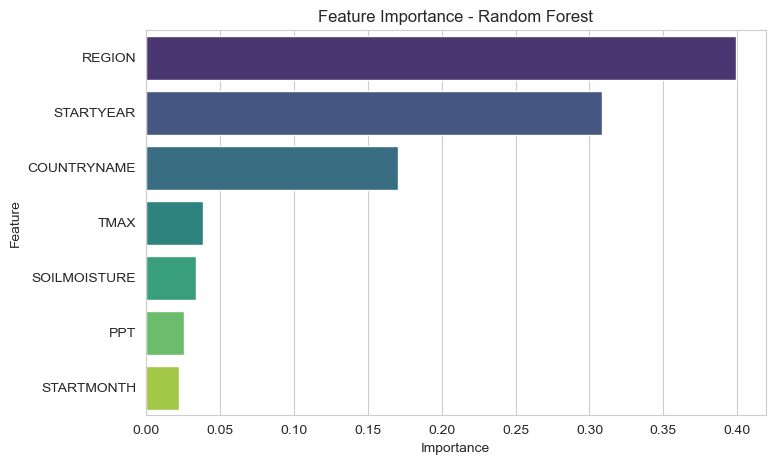

In [144]:
model = joblib.load("../models/random_forest.pkl")

importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[sorted_idx], y=X_train.columns[sorted_idx], palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.savefig("../plots/random_forest_f-i")
plt.show()

### *Insight:*

*REGION* and *STARTYEAR* are the top features, reinforcing the importance of location and time in predicting locust outbreaks. *SOILMOISTURE* and *PPT* are moderately important, reflecting the role of environmental factors. *STARTMONTH* has lower importance, suggesting seasonal patterns are less critical than annual trends.

### *2. XGBoost*

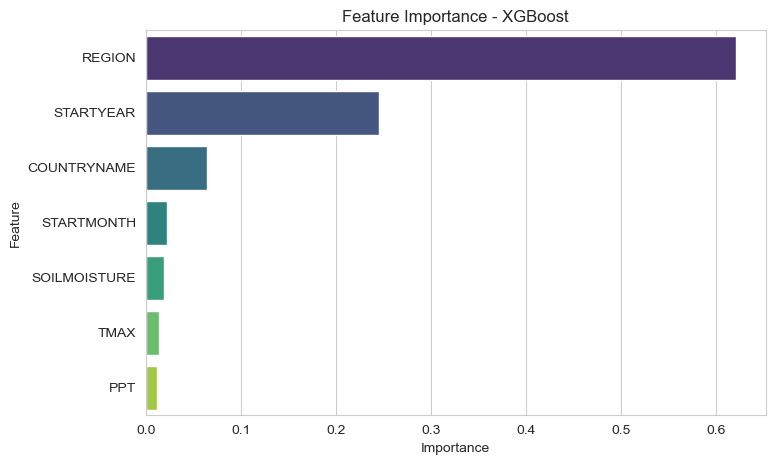

In [147]:
model = joblib.load("../models/xgboost.pkl")

importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[sorted_idx], y=X_train.columns[sorted_idx], palette="viridis")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("../plots/xgboost_f-i")
plt.show()

### *Insight:*

*REGION* and *STARTYEAR* are the most influential features, consistent with other models. *SOILMOISTURE* and *PPT* are also significant, underscoring the importance of soil and rainfall conditions. *TMAX* and *STARTMONTH* have lower importance, indicating that temperature and seasonal timing are secondary factors.

### *3. LightGBM*

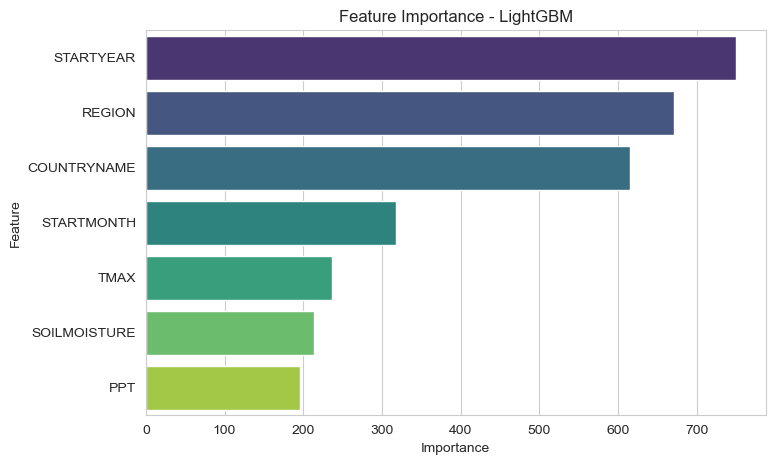

In [146]:
model = joblib.load("../models/lightgbm.pkl")

importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[sorted_idx], y=X_train.columns[sorted_idx], palette="viridis")
plt.title("Feature Importance - LightGBM")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("../plots/lightgbm_f-i")
plt.show()


### *Insight:*

*STARTYEAR* dominates feature importance, suggesting that locust outbreaks are strongly influenced by yearly trends, possibly due to climate change. *REGION* and *COUNTRYNAME* follow, emphasizing the geographic variability of locust activity. *SOILMOISTURE* and *TMAX* (temperature) are less critical but still relevant.

### *4. Gradient Boosting*

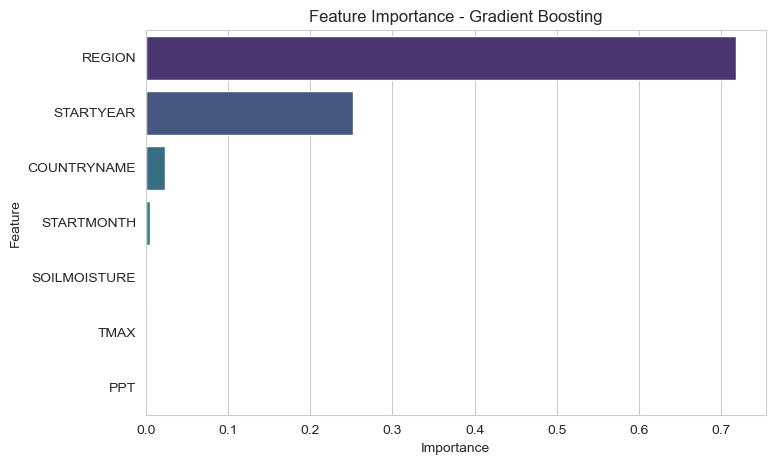

In [151]:
model = joblib.load("../models/gradient_boosting.pkl")

importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[sorted_idx], y=X_train.columns[sorted_idx], palette="viridis")
plt.title("Feature Importance - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("../plots/gradient_boost_f-i")
plt.show()


### *Insight:*

*REGION* and *STARTYEAR* are the most important features, indicating that locust outbreaks are highly dependent on geographic and temporal factors. *SOILMOISTURE* and *PPT* (precipitation) also play significant roles, highlighting the impact of environmental conditions on locust behavior.

# 6.0: Hyperparameter Tuning

## *1. Random Forest*

In [ ]:
# Define hyperparameter grid
rf_params = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search
rf_search = RandomizedSearchCV(rf_model, rf_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42)
rf_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for Random Forest:", rf_search.best_params_)
print("Best Accuracy:", rf_search.best_score_)

# Save the best model
joblib.dump(rf_search.best_estimator_, "../models/random_forest_tuned.pkl")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


## *2. XGBoost*

In [ ]:
# Define hyperparameter grid
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10]
}

# Initialize model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Perform Randomized Search
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42)
xgb_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for XGBoost:", xgb_search.best_params_)
print("Best Accuracy:", xgb_search.best_score_)

# Save the best model
joblib.dump(xgb_search.best_estimator_, "../models/xgboost_tuned.pkl")

## *3. LightGBM*

In [ ]:
# Define hyperparameter grid
lgb_params = {
    "num_leaves": [20, 31, 50, 100],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300, 500]
}

# Initialize model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Perform Randomized Search
lgb_search = RandomizedSearchCV(lgb_model, lgb_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42)
lgb_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for LightGBM:", lgb_search.best_params_)
print("Best Accuracy:", lgb_search.best_score_)

# Save the best model
joblib.dump(lgb_search.best_estimator_, "../models/lightgbm_tuned.pkl")

## *4: Gradient Boosting*

In [ ]:
# Define hyperparameter grid
gb_params = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10]
}

# Initialize model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform Randomized Search
gb_search = RandomizedSearchCV(gb_model, gb_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42)
gb_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for Gradient Boosting:", gb_search.best_params_)
print("Best Accuracy:", gb_search.best_score_)

# Save the best model
joblib.dump(gb_search.best_estimator_, "../models/gradient_boosting_tuned.pkl")

## *5. SVM*

In [ ]:
# Define hyperparameter grid
svm_params = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.01, 0.1, 1, "scale"],
    "kernel": ["rbf", "linear"]
}

# Initialize model
svm_model = SVC(probability=True, random_state=42)

# Perform Randomized Search
svm_search = RandomizedSearchCV(svm_model, svm_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42)
svm_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for SVM:", svm_search.best_params_)
print("Best Accuracy:", svm_search.best_score_)

# Save the best model
joblib.dump(svm_search.best_estimator_, "../models/svm_tuned.pkl")